In [4]:
import numpy as np
import matplotlib.pyplot as plt
from preprocess_images import data_from_folder
from tqdm import tqdm

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import cv2 
import wandb

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [6]:
data = data_from_folder("./data/125x125_laser_x4_y6", grayscale=True)
# data = data_from_folder("./data/laser_x4_y6")
# data = data_from_folder("./data/test")

x-0.00_y-0.10.jpg


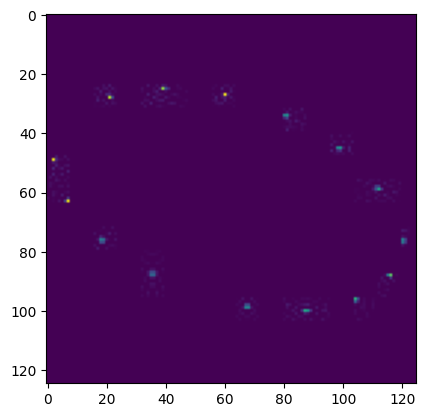

In [7]:
for k in data:
    print(k)
    plt.imshow(data[k], vmin=0, vmax=255)
    # plt.show()
    break

In [8]:
def imname_to_target(name:str) -> tuple[float]:
    """Parses image names of format x{x_value}_y{y_value}.jpg"""
    name = name.split('.jpg')[0]
    x, y = name.split("_")
    x = float(x[1:])
    y = float(y[1:])
    return x, y

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, images, targets, transform=None):
        self.images = images
        self.targets = targets
        self.transform = transform

        self.in_channels = 3
        if len(self.images[0].shape) == 2:
            self.in_channels = 1
        else:
            self.in_channels = self.images[0].shape[2] # TODO check
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]  # Get image (NumPy array)
        label = self.targets[index]  # Get corresponding tuple

        # Convert image to Tensor and normalize [0,1]
        image = torch.from_numpy(image)
        if len(image.shape)==3:
            image = image.permute(2, 0, 1)  # HWC -> CHW
        else:
            image = image.unsqueeze(0)
        image = image.float() / 255.0

        # Convert label tuple to Tensor
        label = torch.tensor(label, dtype=torch.float32)

        # Apply transforms if specified
        if self.transform:
            image = self.transform(image)

        return image, label


class FlatGrayImageDataset(Dataset):
    def __init__(self, images, targets):
        self.images = images
        self.targets = targets
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]  # Get image (NumPy array)
        label = self.targets[index]  # Get corresponding tuple
        
        # Convert image to Tensor, flatten, and normalize [0,1]
        image = torch.from_numpy(image).flatten()
        image = image.float() / 255.0
        
        # Convert label tuple to Tensor
        label = torch.tensor(label, dtype=torch.float32)

        return image, label

In [10]:
a = np.zeros((125, 125))
a = torch.from_numpy(a)
print(a.shape)
a = a.flatten()
print(a.shape)

torch.Size([125, 125])
torch.Size([15625])


In [11]:
config = {
    "experiment_name": "fc_4layers_4000batch_500epochs_50cosinescheduler",
    "batch_size": 4000,
    "lr": 0.001,
    "lr_scheduler_loop": 50,
    "epochs": 500,
}

In [12]:
# Prepare dataset
images = []
targets = []
for name, image in data.items():
    targets.append(imname_to_target(name))
    images.append(image)
# dataset = ImageDataset(images, targets)
dataset = FlatGrayImageDataset(images, targets)
data_loader = DataLoader(dataset, config["batch_size"], True)

In [37]:
print(dataset[0][0].shape)
# print(dataset.in_channels)

torch.Size([15625])


In [14]:
class SimpleCNN(nn.Module):
    def __init__(self, output_size, in_channels):
        super(SimpleCNN, self).__init__()
        self.sec1 = nn.Sequential(
            nn.Conv2d(in_channels, 32, 5, 2), # 3, 250 -> 32, 125
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 32, 125 -> 32, 62

            nn.Conv2d(32, 64, 3, 2), # 32, 62 -> 64, 31
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 64, 31 -> 64, 15

            nn.Conv2d(64, 128, 3, 2), # 64, 15 -> 128, 7
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # 128, 7 -> 128, 3
        )

        self.sec2 = nn.Sequential(
            nn.Linear(128*3*3, 256),
            nn.ReLU(),
            nn.Linear(256, output_size),
        )

    def forward(self, x):
        x = self.sec1(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.sec2(x)

        return x
    
class SimpleFC(nn.Module):
    def __init__(self, out_features):
        super(SimpleFC, self).__init__()
        self.relu = nn.ReLU()
        self.layers = nn.Sequential(
            nn.Linear(125*125, 1024), # 15,625 -> 1024
            nn.BatchNorm1d(1024),
            self.relu,
            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            self.relu,
            nn.Linear(256, 32),
            nn.BatchNorm1d(32),
            self.relu,
            nn.Linear(32, out_features),
        )
    def forward(self, x):
        return self.layers.forward(x)
        

In [15]:
# model = SimpleCNN(output_size=2, in_channels=data_loader.in_channels).to(DEVICE)
# summary(model, (data_loader.in_channels, 250, 250))


model = SimpleFC(2).to(DEVICE)
summary(model, (125*125,), config["batch_size"])

optimizer = optim.AdamW(model.parameters(), config["lr"])
criterion = nn.MSELoss()
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, config["lr_scheduler_loop"], eta_min=0.00001)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [4000, 1024]      16,001,024
       BatchNorm1d-2               [4000, 1024]           2,048
              ReLU-3               [4000, 1024]               0
              ReLU-4               [4000, 1024]               0
            Linear-5                [4000, 256]         262,400
       BatchNorm1d-6                [4000, 256]             512
              ReLU-7                [4000, 256]               0
              ReLU-8                [4000, 256]               0
            Linear-9                 [4000, 32]           8,224
      BatchNorm1d-10                 [4000, 32]              64
             ReLU-11                 [4000, 32]               0
             ReLU-12                 [4000, 32]               0
           Linear-13                  [4000, 2]              66
Total params: 16,274,338
Trainable para

In [16]:
def save_model(model:torch.nn.Module, fname="best_model.pth", path="./saved_models/"):
    torch.save(model.state_dict(), path+fname)

def load_model(model:torch.nn.Module, fname="best_model.pth", path="./saved_models/"):
    model.load_state_dict(torch.load(path+fname, weights_only=False))

In [17]:
wandb.login(key="a41d74c58ab2f0d2c2bbdb317450ab14a8ad9d4e")
wandb.init(
    project="multireflection",
    name=config["experiment_name"],
    config=config,
)
wandb.watch(model, log='all', log_freq=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/evv/.netrc
wandb: Currently logged in as: e-venediktov (e-venediktov-university-of-pittsburgh) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
def train(model, data_loader, optimizer:optim.Optimizer, criterion, scheduler:optim.lr_scheduler.CosineAnnealingWarmRestarts):
    best_loss = 1000000000
    best_model = None

    # Training Loop
    for epoch in range(config['epochs']):
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(data_loader):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        last_lr = scheduler.get_last_lr()[0]
        scheduler.step()

        avg_train_loss = running_loss / len(data_loader)
        print(f"Epoch {epoch + 1}/{config['epochs']}, Train Loss: {avg_train_loss:.4f}")

        if avg_train_loss < best_loss:
            best_model = model
            best_loss = avg_train_loss
            save_model(model, fname=config["experiment_name"]+"_best_model.pth")

        # ✅ Log Training Loss
        wandb.log({"Train Loss": avg_train_loss, "LR": last_lr, "best_loss":best_loss})

    print("Best loss:", best_loss)
    return model, best_model


In [19]:
model, best = train(model, data_loader, optimizer, criterion, scheduler)

100%|██████████| 2/2 [00:00<00:00,  5.37it/s]


Epoch 1/500, Train Loss: 4.3382


100%|██████████| 2/2 [00:00<00:00,  7.59it/s]


Epoch 2/500, Train Loss: 3.1905


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch 3/500, Train Loss: 2.3577


100%|██████████| 2/2 [00:00<00:00,  8.01it/s]


Epoch 4/500, Train Loss: 2.1311


100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Epoch 5/500, Train Loss: 2.1609


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 6/500, Train Loss: 1.9096


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Epoch 7/500, Train Loss: 1.5982


100%|██████████| 2/2 [00:00<00:00,  6.50it/s]


Epoch 8/500, Train Loss: 1.4783


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 9/500, Train Loss: 1.5969


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch 10/500, Train Loss: 1.4662


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch 11/500, Train Loss: 1.4805


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 12/500, Train Loss: 1.3932


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 13/500, Train Loss: 1.3955


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 14/500, Train Loss: 1.2459


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 15/500, Train Loss: 1.1870


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 16/500, Train Loss: 1.1166


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Epoch 17/500, Train Loss: 1.1293


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch 18/500, Train Loss: 1.0961


100%|██████████| 2/2 [00:00<00:00,  8.78it/s]


Epoch 19/500, Train Loss: 1.1565


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 20/500, Train Loss: 1.0230


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 21/500, Train Loss: 1.1023


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 22/500, Train Loss: 1.0748


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch 23/500, Train Loss: 0.8436


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch 24/500, Train Loss: 1.0386


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 25/500, Train Loss: 0.8664


100%|██████████| 2/2 [00:00<00:00,  5.92it/s]


Epoch 26/500, Train Loss: 0.8905


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch 27/500, Train Loss: 0.9599


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 28/500, Train Loss: 0.8056


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 29/500, Train Loss: 0.7157


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 30/500, Train Loss: 0.8144


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 31/500, Train Loss: 0.8025


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


Epoch 32/500, Train Loss: 0.7823


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch 33/500, Train Loss: 0.7901


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 34/500, Train Loss: 0.6737


100%|██████████| 2/2 [00:00<00:00,  5.91it/s]


Epoch 35/500, Train Loss: 0.6897


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 36/500, Train Loss: 0.8139


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch 37/500, Train Loss: 0.6722


100%|██████████| 2/2 [00:00<00:00,  9.02it/s]


Epoch 38/500, Train Loss: 0.7336


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch 39/500, Train Loss: 0.7653


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch 40/500, Train Loss: 0.6588


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 41/500, Train Loss: 0.7463


100%|██████████| 2/2 [-1:59:59<00:00, -1.11it/s]


Epoch 42/500, Train Loss: 0.6019


100%|██████████| 2/2 [00:00<00:00,  8.82it/s]


Epoch 43/500, Train Loss: 0.6630


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Epoch 44/500, Train Loss: 0.6551


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch 45/500, Train Loss: 0.6486


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 46/500, Train Loss: 0.6762


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 47/500, Train Loss: 0.8641


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 48/500, Train Loss: 0.6577


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 49/500, Train Loss: 0.7836


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Epoch 50/500, Train Loss: 0.7554


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch 51/500, Train Loss: 0.6755


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 52/500, Train Loss: 0.6208


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch 53/500, Train Loss: 0.7730


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 54/500, Train Loss: 0.5783


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch 55/500, Train Loss: 0.5473


100%|██████████| 2/2 [00:00<00:00,  8.53it/s]


Epoch 56/500, Train Loss: 0.5961


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 57/500, Train Loss: 0.6350


100%|██████████| 2/2 [00:00<00:00,  9.01it/s]


Epoch 58/500, Train Loss: 0.5645


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch 59/500, Train Loss: 0.4419


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch 60/500, Train Loss: 0.5519


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 61/500, Train Loss: 0.4714


100%|██████████| 2/2 [00:00<00:00,  6.04it/s]


Epoch 62/500, Train Loss: 0.5496


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch 63/500, Train Loss: 0.4595


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 64/500, Train Loss: 0.4853


100%|██████████| 2/2 [00:00<00:00,  8.91it/s]


Epoch 65/500, Train Loss: 0.5181


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 66/500, Train Loss: 0.4927


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 67/500, Train Loss: 0.4839


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch 68/500, Train Loss: 0.4641


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 69/500, Train Loss: 0.4720


100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Epoch 70/500, Train Loss: 0.3543


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]


Epoch 71/500, Train Loss: 0.3953


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch 72/500, Train Loss: 0.4360


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 73/500, Train Loss: 0.4558


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch 74/500, Train Loss: 0.3916


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch 75/500, Train Loss: 0.3277


100%|██████████| 2/2 [00:00<00:00,  8.90it/s]


Epoch 76/500, Train Loss: 0.4608


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 77/500, Train Loss: 0.4228


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 78/500, Train Loss: 0.4042


100%|██████████| 2/2 [00:00<00:00,  8.68it/s]


Epoch 79/500, Train Loss: 0.3621


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch 80/500, Train Loss: 0.3881


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 81/500, Train Loss: 0.4107


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 82/500, Train Loss: 0.4831


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 83/500, Train Loss: 0.3644


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 84/500, Train Loss: 0.4216


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 85/500, Train Loss: 0.4039


100%|██████████| 2/2 [00:00<00:00,  7.55it/s]


Epoch 86/500, Train Loss: 0.3040


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch 87/500, Train Loss: 0.4316


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 88/500, Train Loss: 0.3976


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Epoch 89/500, Train Loss: 0.4837


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 90/500, Train Loss: 0.5106


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch 91/500, Train Loss: 0.3481


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 92/500, Train Loss: 0.3836


100%|██████████| 2/2 [00:00<00:00,  7.60it/s]


Epoch 93/500, Train Loss: 0.3616


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 94/500, Train Loss: 0.4864


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 95/500, Train Loss: 0.4203


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch 96/500, Train Loss: 0.4128


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 97/500, Train Loss: 0.3130


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Epoch 98/500, Train Loss: 0.3845


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 99/500, Train Loss: 0.3547


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Epoch 100/500, Train Loss: 0.3337


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 101/500, Train Loss: 0.4427


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch 102/500, Train Loss: 0.3329


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 103/500, Train Loss: 0.4183


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch 104/500, Train Loss: 0.4173


100%|██████████| 2/2 [00:00<00:00,  6.54it/s]


Epoch 105/500, Train Loss: 0.3689


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 106/500, Train Loss: 0.3021


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Epoch 107/500, Train Loss: 0.4513


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 108/500, Train Loss: 0.4272


100%|██████████| 2/2 [00:00<00:00,  6.52it/s]


Epoch 109/500, Train Loss: 0.3496


100%|██████████| 2/2 [00:00<00:00,  6.18it/s]


Epoch 110/500, Train Loss: 0.3720


100%|██████████| 2/2 [00:00<00:00,  7.68it/s]


Epoch 111/500, Train Loss: 0.2731


100%|██████████| 2/2 [00:00<00:00,  7.74it/s]


Epoch 112/500, Train Loss: 0.4568


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 113/500, Train Loss: 0.4119


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 114/500, Train Loss: 0.4054


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 115/500, Train Loss: 0.3749


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch 116/500, Train Loss: 0.4448


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 117/500, Train Loss: 0.3510


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 118/500, Train Loss: 0.3639


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 119/500, Train Loss: 0.4422


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 120/500, Train Loss: 0.3646


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 121/500, Train Loss: 0.4017


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 122/500, Train Loss: 0.3828


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 123/500, Train Loss: 0.4575


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


Epoch 124/500, Train Loss: 0.4601


100%|██████████| 2/2 [00:00<00:00,  5.48it/s]


Epoch 125/500, Train Loss: 0.4376


100%|██████████| 2/2 [00:00<00:00,  8.02it/s]


Epoch 126/500, Train Loss: 0.4226


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch 127/500, Train Loss: 0.4441


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch 128/500, Train Loss: 0.3899


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 129/500, Train Loss: 0.3776


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 130/500, Train Loss: 0.4015


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 131/500, Train Loss: 0.3436


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch 132/500, Train Loss: 0.3728


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 133/500, Train Loss: 0.4591


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Epoch 134/500, Train Loss: 0.3589


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch 135/500, Train Loss: 0.3210


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch 136/500, Train Loss: 0.4422


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 137/500, Train Loss: 0.3439


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch 138/500, Train Loss: 0.3348


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch 139/500, Train Loss: 0.4459


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 140/500, Train Loss: 0.3341


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 141/500, Train Loss: 0.4106


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 142/500, Train Loss: 0.2952


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Epoch 143/500, Train Loss: 0.3842


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 144/500, Train Loss: 0.3800


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 145/500, Train Loss: 0.4184


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch 146/500, Train Loss: 0.3822


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 147/500, Train Loss: 0.3167


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 148/500, Train Loss: 0.3097


100%|██████████| 2/2 [00:00<00:00,  7.03it/s]


Epoch 149/500, Train Loss: 0.2807


100%|██████████| 2/2 [00:00<00:00,  5.61it/s]


Epoch 150/500, Train Loss: 0.4002


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch 151/500, Train Loss: 0.3833


100%|██████████| 2/2 [00:00<00:00,  5.10it/s]


Epoch 152/500, Train Loss: 0.3297


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch 153/500, Train Loss: 0.3945


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 154/500, Train Loss: 0.3988


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 155/500, Train Loss: 0.3588


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch 156/500, Train Loss: 0.4960


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 157/500, Train Loss: 0.3518


100%|██████████| 2/2 [-1:59:59<00:00, -1.14it/s]


Epoch 158/500, Train Loss: 0.3733


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 159/500, Train Loss: 0.3410


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 160/500, Train Loss: 0.4031


100%|██████████| 2/2 [00:00<00:00,  5.85it/s]


Epoch 161/500, Train Loss: 0.4270


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 162/500, Train Loss: 0.4089


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch 163/500, Train Loss: 0.4616


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 164/500, Train Loss: 0.3238


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 165/500, Train Loss: 0.3515


100%|██████████| 2/2 [00:00<00:00,  6.99it/s]


Epoch 166/500, Train Loss: 0.3617


100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 167/500, Train Loss: 0.3582


100%|██████████| 2/2 [00:00<00:00,  7.44it/s]


Epoch 168/500, Train Loss: 0.3916


100%|██████████| 2/2 [00:00<00:00,  6.90it/s]


Epoch 169/500, Train Loss: 0.5258


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Epoch 170/500, Train Loss: 0.4028


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 171/500, Train Loss: 0.3843


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch 172/500, Train Loss: 0.4068


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 173/500, Train Loss: 0.4421


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch 174/500, Train Loss: 0.4331


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 175/500, Train Loss: 0.4238


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch 176/500, Train Loss: 0.4151


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch 177/500, Train Loss: 0.4248


100%|██████████| 2/2 [00:00<00:00,  8.89it/s]


Epoch 178/500, Train Loss: 0.3037


100%|██████████| 2/2 [00:00<00:00,  5.72it/s]


Epoch 179/500, Train Loss: 0.3734


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 180/500, Train Loss: 0.3677


100%|██████████| 2/2 [00:00<00:00,  8.03it/s]


Epoch 181/500, Train Loss: 0.3546


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch 182/500, Train Loss: 0.3151


100%|██████████| 2/2 [00:00<00:00,  6.97it/s]


Epoch 183/500, Train Loss: 0.4875


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 184/500, Train Loss: 0.3047


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 185/500, Train Loss: 0.3149


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch 186/500, Train Loss: 0.3818


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch 187/500, Train Loss: 0.3939


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 188/500, Train Loss: 0.3835


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 189/500, Train Loss: 0.3950


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch 190/500, Train Loss: 0.3376


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 191/500, Train Loss: 0.3891


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


Epoch 192/500, Train Loss: 0.3641


100%|██████████| 2/2 [00:00<00:00,  5.66it/s]


Epoch 193/500, Train Loss: 0.4424


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch 194/500, Train Loss: 0.3576


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch 195/500, Train Loss: 0.2892


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 196/500, Train Loss: 0.4031


100%|██████████| 2/2 [00:00<00:00,  5.87it/s]


Epoch 197/500, Train Loss: 0.3311


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 198/500, Train Loss: 0.2962


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 199/500, Train Loss: 0.3939


100%|██████████| 2/2 [00:00<00:00,  5.74it/s]


Epoch 200/500, Train Loss: 0.3889


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch 201/500, Train Loss: 0.3848


100%|██████████| 2/2 [00:00<00:00,  8.99it/s]


Epoch 202/500, Train Loss: 0.4031


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 203/500, Train Loss: 0.3561


100%|██████████| 2/2 [00:00<00:00,  8.85it/s]


Epoch 204/500, Train Loss: 0.3425


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 205/500, Train Loss: 0.3028


100%|██████████| 2/2 [00:00<00:00,  6.12it/s]


Epoch 206/500, Train Loss: 0.4964


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch 207/500, Train Loss: 0.3339


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch 208/500, Train Loss: 0.4317


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch 209/500, Train Loss: 0.4688


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 210/500, Train Loss: 0.4144


100%|██████████| 2/2 [00:00<00:00,  8.77it/s]


Epoch 211/500, Train Loss: 0.4649


100%|██████████| 2/2 [00:00<00:00,  8.79it/s]


Epoch 212/500, Train Loss: 0.4316


100%|██████████| 2/2 [00:00<00:00,  7.13it/s]


Epoch 213/500, Train Loss: 0.4305


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 214/500, Train Loss: 0.3865


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 215/500, Train Loss: 0.3497


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 216/500, Train Loss: 0.3878


100%|██████████| 2/2 [00:00<00:00,  7.32it/s]


Epoch 217/500, Train Loss: 0.3245


100%|██████████| 2/2 [00:00<00:00,  8.75it/s]


Epoch 218/500, Train Loss: 0.2842


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch 219/500, Train Loss: 0.3598


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch 220/500, Train Loss: 0.4046


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 221/500, Train Loss: 0.3330


100%|██████████| 2/2 [00:00<00:00,  8.72it/s]


Epoch 222/500, Train Loss: 0.3263


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 223/500, Train Loss: 0.3415


100%|██████████| 2/2 [00:00<00:00,  5.96it/s]


Epoch 224/500, Train Loss: 0.3290


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 225/500, Train Loss: 0.4424


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Epoch 226/500, Train Loss: 0.3754


100%|██████████| 2/2 [00:00<00:00,  7.21it/s]


Epoch 227/500, Train Loss: 0.4160


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch 228/500, Train Loss: 0.3878


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 229/500, Train Loss: 0.3748


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 230/500, Train Loss: 0.3009


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch 231/500, Train Loss: 0.3054


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch 232/500, Train Loss: 0.2812


100%|██████████| 2/2 [00:00<00:00,  5.82it/s]


Epoch 233/500, Train Loss: 0.3327


100%|██████████| 2/2 [00:00<00:00,  7.05it/s]


Epoch 234/500, Train Loss: 0.3341


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 235/500, Train Loss: 0.3794


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 236/500, Train Loss: 0.3816


100%|██████████| 2/2 [00:00<00:00,  8.81it/s]


Epoch 237/500, Train Loss: 0.3793


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 238/500, Train Loss: 0.3308


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 239/500, Train Loss: 0.3240


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 240/500, Train Loss: 0.3361


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 241/500, Train Loss: 0.2897


100%|██████████| 2/2 [00:00<00:00,  5.88it/s]


Epoch 242/500, Train Loss: 0.3256


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Epoch 243/500, Train Loss: 0.3252


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Epoch 244/500, Train Loss: 0.3625


100%|██████████| 2/2 [00:00<00:00,  7.27it/s]


Epoch 245/500, Train Loss: 0.3283


100%|██████████| 2/2 [00:00<00:00,  4.97it/s]


Epoch 246/500, Train Loss: 0.3841


100%|██████████| 2/2 [00:00<00:00,  7.51it/s]


Epoch 247/500, Train Loss: 0.4886


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 248/500, Train Loss: 0.3881


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 249/500, Train Loss: 0.3326


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Epoch 250/500, Train Loss: 0.3601


100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


Epoch 251/500, Train Loss: 0.2661


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 252/500, Train Loss: 0.3417


100%|██████████| 2/2 [00:00<00:00,  8.13it/s]


Epoch 253/500, Train Loss: 0.3784


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 254/500, Train Loss: 0.3511


100%|██████████| 2/2 [00:00<00:00,  8.67it/s]


Epoch 255/500, Train Loss: 0.4049


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 256/500, Train Loss: 0.3534


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 257/500, Train Loss: 0.3694


100%|██████████| 2/2 [00:00<00:00,  7.20it/s]


Epoch 258/500, Train Loss: 0.3685


100%|██████████| 2/2 [00:00<00:00,  6.27it/s]


Epoch 259/500, Train Loss: 0.3355


100%|██████████| 2/2 [00:00<00:00,  5.57it/s]


Epoch 260/500, Train Loss: 0.4897


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 261/500, Train Loss: 0.4048


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 262/500, Train Loss: 0.3185


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch 263/500, Train Loss: 0.2865


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 264/500, Train Loss: 0.4143


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 265/500, Train Loss: 0.3361


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 266/500, Train Loss: 0.3810


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 267/500, Train Loss: 0.3156


100%|██████████| 2/2 [00:00<00:00,  8.60it/s]


Epoch 268/500, Train Loss: 0.4015


100%|██████████| 2/2 [00:00<00:00,  5.98it/s]


Epoch 269/500, Train Loss: 0.3242


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 270/500, Train Loss: 0.4564


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 271/500, Train Loss: 0.3034


100%|██████████| 2/2 [00:00<00:00,  7.99it/s]


Epoch 272/500, Train Loss: 0.3277


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 273/500, Train Loss: 0.3609


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 274/500, Train Loss: 0.3729


100%|██████████| 2/2 [00:00<00:00,  6.91it/s]


Epoch 275/500, Train Loss: 0.3583


100%|██████████| 2/2 [00:00<00:00,  8.57it/s]


Epoch 276/500, Train Loss: 0.3401


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 277/500, Train Loss: 0.3486


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch 278/500, Train Loss: 0.3994


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 279/500, Train Loss: 0.3430


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 280/500, Train Loss: 0.4004


100%|██████████| 2/2 [-1:59:59<00:00, -1.18it/s]


Epoch 281/500, Train Loss: 0.4015


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 282/500, Train Loss: 0.3359


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 283/500, Train Loss: 0.2822


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 284/500, Train Loss: 0.4493


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 285/500, Train Loss: 0.3417


100%|██████████| 2/2 [00:00<00:00,  7.94it/s]


Epoch 286/500, Train Loss: 0.3801


100%|██████████| 2/2 [00:00<00:00,  5.78it/s]


Epoch 287/500, Train Loss: 0.3770


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch 288/500, Train Loss: 0.4588


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 289/500, Train Loss: 0.3943


100%|██████████| 2/2 [00:00<00:00,  8.31it/s]


Epoch 290/500, Train Loss: 0.4325


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 291/500, Train Loss: 0.3762


100%|██████████| 2/2 [00:00<00:00,  7.14it/s]


Epoch 292/500, Train Loss: 0.2772


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 293/500, Train Loss: 0.3890


100%|██████████| 2/2 [00:00<00:00,  8.54it/s]


Epoch 294/500, Train Loss: 0.3581


100%|██████████| 2/2 [00:00<00:00,  8.47it/s]


Epoch 295/500, Train Loss: 0.3246


100%|██████████| 2/2 [00:00<00:00,  6.00it/s]


Epoch 296/500, Train Loss: 0.2837


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 297/500, Train Loss: 0.3432


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 298/500, Train Loss: 0.3298


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 299/500, Train Loss: 0.3436


100%|██████████| 2/2 [00:00<00:00,  6.14it/s]


Epoch 300/500, Train Loss: 0.4203


100%|██████████| 2/2 [00:00<00:00,  8.66it/s]


Epoch 301/500, Train Loss: 0.3362


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 302/500, Train Loss: 0.5376


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 303/500, Train Loss: 0.3395


100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch 304/500, Train Loss: 0.4109


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch 305/500, Train Loss: 0.4029


100%|██████████| 2/2 [00:00<00:00,  8.58it/s]


Epoch 306/500, Train Loss: 0.3236


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch 307/500, Train Loss: 0.4591


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 308/500, Train Loss: 0.3742


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 309/500, Train Loss: 0.3035


100%|██████████| 2/2 [00:00<00:00,  8.65it/s]


Epoch 310/500, Train Loss: 0.3777


100%|██████████| 2/2 [00:00<00:00,  8.83it/s]


Epoch 311/500, Train Loss: 0.3961


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 312/500, Train Loss: 0.4470


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 313/500, Train Loss: 0.3287


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Epoch 314/500, Train Loss: 0.5280


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 315/500, Train Loss: 0.3923


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 316/500, Train Loss: 0.3462


100%|██████████| 2/2 [00:00<00:00,  6.67it/s]


Epoch 317/500, Train Loss: 0.3589


100%|██████████| 2/2 [00:00<00:00,  5.73it/s]


Epoch 318/500, Train Loss: 0.4001


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Epoch 319/500, Train Loss: 0.3454


100%|██████████| 2/2 [00:00<00:00,  7.38it/s]


Epoch 320/500, Train Loss: 0.4825


100%|██████████| 2/2 [00:00<00:00,  7.00it/s]


Epoch 321/500, Train Loss: 0.2984


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch 322/500, Train Loss: 0.4243


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Epoch 323/500, Train Loss: 0.3919


100%|██████████| 2/2 [00:00<00:00,  6.81it/s]


Epoch 324/500, Train Loss: 0.3858


100%|██████████| 2/2 [00:00<00:00,  7.92it/s]


Epoch 325/500, Train Loss: 0.3114


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch 326/500, Train Loss: 0.4563


100%|██████████| 2/2 [00:00<00:00,  8.28it/s]


Epoch 327/500, Train Loss: 0.2872


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 328/500, Train Loss: 0.3674


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 329/500, Train Loss: 0.3687


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 330/500, Train Loss: 0.4149


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 331/500, Train Loss: 0.3170


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Epoch 332/500, Train Loss: 0.3362


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 333/500, Train Loss: 0.3588


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 334/500, Train Loss: 0.3235


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 335/500, Train Loss: 0.4344


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 336/500, Train Loss: 0.3657


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 337/500, Train Loss: 0.3476


100%|██████████| 2/2 [00:00<00:00,  8.59it/s]


Epoch 338/500, Train Loss: 0.3500


100%|██████████| 2/2 [00:00<00:00,  8.51it/s]


Epoch 339/500, Train Loss: 0.3673


100%|██████████| 2/2 [00:00<00:00,  8.71it/s]


Epoch 340/500, Train Loss: 0.3393


100%|██████████| 2/2 [00:00<00:00,  5.20it/s]


Epoch 341/500, Train Loss: 0.3648


100%|██████████| 2/2 [00:00<00:00,  4.69it/s]


Epoch 342/500, Train Loss: 0.3919


100%|██████████| 2/2 [00:00<00:00,  4.80it/s]


Epoch 343/500, Train Loss: 0.3232


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Epoch 344/500, Train Loss: 0.2933


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 345/500, Train Loss: 0.4340


100%|██████████| 2/2 [00:00<00:00,  8.63it/s]


Epoch 346/500, Train Loss: 0.3739


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch 347/500, Train Loss: 0.4300


100%|██████████| 2/2 [00:00<00:00,  7.22it/s]


Epoch 348/500, Train Loss: 0.3909


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 349/500, Train Loss: 0.4406


100%|██████████| 2/2 [00:00<00:00,  4.64it/s]


Epoch 350/500, Train Loss: 0.4636


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 351/500, Train Loss: 0.3537


100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


Epoch 352/500, Train Loss: 0.4021


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch 353/500, Train Loss: 0.3906


100%|██████████| 2/2 [00:00<00:00,  8.15it/s]


Epoch 354/500, Train Loss: 0.3272


100%|██████████| 2/2 [00:00<00:00,  7.85it/s]


Epoch 355/500, Train Loss: 0.4246


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch 356/500, Train Loss: 0.3085


100%|██████████| 2/2 [00:00<00:00,  8.14it/s]


Epoch 357/500, Train Loss: 0.3766


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 358/500, Train Loss: 0.3332


100%|██████████| 2/2 [00:00<00:00,  5.67it/s]


Epoch 359/500, Train Loss: 0.3846


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 360/500, Train Loss: 0.3498


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 361/500, Train Loss: 0.3808


100%|██████████| 2/2 [00:00<00:00,  8.27it/s]


Epoch 362/500, Train Loss: 0.3092


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 363/500, Train Loss: 0.3019


100%|██████████| 2/2 [00:00<00:00,  8.20it/s]


Epoch 364/500, Train Loss: 0.2903


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch 365/500, Train Loss: 0.3192


100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


Epoch 366/500, Train Loss: 0.2210


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch 367/500, Train Loss: 0.3500


100%|██████████| 2/2 [00:00<00:00,  5.56it/s]


Epoch 368/500, Train Loss: 0.2935


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]


Epoch 369/500, Train Loss: 0.3032


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 370/500, Train Loss: 0.3245


100%|██████████| 2/2 [00:00<00:00,  7.91it/s]


Epoch 371/500, Train Loss: 0.3998


100%|██████████| 2/2 [00:00<00:00,  6.71it/s]


Epoch 372/500, Train Loss: 0.4341


100%|██████████| 2/2 [00:00<00:00,  6.86it/s]


Epoch 373/500, Train Loss: 0.4159


100%|██████████| 2/2 [00:00<00:00,  7.97it/s]


Epoch 374/500, Train Loss: 0.4777


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 375/500, Train Loss: 0.3259


100%|██████████| 2/2 [00:00<00:00,  8.08it/s]


Epoch 376/500, Train Loss: 0.2966


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Epoch 377/500, Train Loss: 0.3074


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch 378/500, Train Loss: 0.3807


100%|██████████| 2/2 [00:00<00:00,  8.00it/s]


Epoch 379/500, Train Loss: 0.3688


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 380/500, Train Loss: 0.2939


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch 381/500, Train Loss: 0.3070


100%|██████████| 2/2 [00:00<00:00,  7.79it/s]


Epoch 382/500, Train Loss: 0.4553


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch 383/500, Train Loss: 0.2554


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 384/500, Train Loss: 0.3650


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 385/500, Train Loss: 0.3448


100%|██████████| 2/2 [00:00<00:00,  5.80it/s]


Epoch 386/500, Train Loss: 0.3132


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 387/500, Train Loss: 0.3511


100%|██████████| 2/2 [00:00<00:00,  8.45it/s]


Epoch 388/500, Train Loss: 0.3316


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 389/500, Train Loss: 0.3432


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 390/500, Train Loss: 0.3762


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 391/500, Train Loss: 0.3623


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 392/500, Train Loss: 0.2274


100%|██████████| 2/2 [00:00<00:00,  7.90it/s]


Epoch 393/500, Train Loss: 0.3363


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 394/500, Train Loss: 0.3863


100%|██████████| 2/2 [00:00<00:00,  5.68it/s]


Epoch 395/500, Train Loss: 0.2792


100%|██████████| 2/2 [00:00<00:00,  6.33it/s]


Epoch 396/500, Train Loss: 0.3438


100%|██████████| 2/2 [00:00<00:00,  4.37it/s]


Epoch 397/500, Train Loss: 0.3419


100%|██████████| 2/2 [00:00<00:00,  5.75it/s]


Epoch 398/500, Train Loss: 0.2930


100%|██████████| 2/2 [00:00<00:00,  7.42it/s]


Epoch 399/500, Train Loss: 0.3268


100%|██████████| 2/2 [-1:59:59<00:00, -1.23it/s]


Epoch 400/500, Train Loss: 0.3159


100%|██████████| 2/2 [00:00<00:00,  8.26it/s]


Epoch 401/500, Train Loss: 0.3602


100%|██████████| 2/2 [00:00<00:00,  8.29it/s]


Epoch 402/500, Train Loss: 0.3813


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Epoch 403/500, Train Loss: 0.3941


100%|██████████| 2/2 [00:00<00:00,  3.64it/s]


Epoch 404/500, Train Loss: 0.3763


100%|██████████| 2/2 [00:00<00:00,  7.70it/s]


Epoch 405/500, Train Loss: 0.3994


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 406/500, Train Loss: 0.4243


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 407/500, Train Loss: 0.4169


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 408/500, Train Loss: 0.2688


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch 409/500, Train Loss: 0.3815


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 410/500, Train Loss: 0.3803


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 411/500, Train Loss: 0.3486


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 412/500, Train Loss: 0.3289


100%|██████████| 2/2 [00:00<00:00,  6.01it/s]


Epoch 413/500, Train Loss: 0.3330


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch 414/500, Train Loss: 0.5418


100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch 415/500, Train Loss: 0.3667


100%|██████████| 2/2 [00:00<00:00,  8.94it/s]


Epoch 416/500, Train Loss: 0.3435


100%|██████████| 2/2 [00:00<00:00,  8.40it/s]


Epoch 417/500, Train Loss: 0.3865


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 418/500, Train Loss: 0.3880


100%|██████████| 2/2 [00:00<00:00,  5.42it/s]


Epoch 419/500, Train Loss: 0.3623


100%|██████████| 2/2 [00:00<00:00,  5.02it/s]


Epoch 420/500, Train Loss: 0.2927


100%|██████████| 2/2 [00:00<00:00,  8.62it/s]


Epoch 421/500, Train Loss: 0.2931


100%|██████████| 2/2 [00:00<00:00,  5.86it/s]


Epoch 422/500, Train Loss: 0.3330


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 423/500, Train Loss: 0.3975


100%|██████████| 2/2 [00:00<00:00,  8.36it/s]


Epoch 424/500, Train Loss: 0.4259


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 425/500, Train Loss: 0.3179


100%|██████████| 2/2 [00:00<00:00,  8.64it/s]


Epoch 426/500, Train Loss: 0.3007


100%|██████████| 2/2 [00:00<00:00,  8.22it/s]


Epoch 427/500, Train Loss: 0.3423


100%|██████████| 2/2 [00:00<00:00,  8.42it/s]


Epoch 428/500, Train Loss: 0.3536


100%|██████████| 2/2 [00:00<00:00,  7.08it/s]


Epoch 429/500, Train Loss: 0.3994


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 430/500, Train Loss: 0.3605


100%|██████████| 2/2 [00:00<00:00,  5.93it/s]


Epoch 431/500, Train Loss: 0.3839


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 432/500, Train Loss: 0.3974


100%|██████████| 2/2 [00:00<00:00,  8.70it/s]


Epoch 433/500, Train Loss: 0.3843


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 434/500, Train Loss: 0.4776


100%|██████████| 2/2 [00:00<00:00,  6.65it/s]


Epoch 435/500, Train Loss: 0.3527


100%|██████████| 2/2 [00:00<00:00,  8.17it/s]


Epoch 436/500, Train Loss: 0.3916


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 437/500, Train Loss: 0.3170


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 438/500, Train Loss: 0.3407


100%|██████████| 2/2 [00:00<00:00,  8.34it/s]


Epoch 439/500, Train Loss: 0.3917


100%|██████████| 2/2 [00:00<00:00,  5.46it/s]


Epoch 440/500, Train Loss: 0.3120


100%|██████████| 2/2 [00:00<00:00,  8.49it/s]


Epoch 441/500, Train Loss: 0.3603


100%|██████████| 2/2 [00:00<00:00,  8.41it/s]


Epoch 442/500, Train Loss: 0.3615


100%|██████████| 2/2 [00:00<00:00,  8.33it/s]


Epoch 443/500, Train Loss: 0.4601


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 444/500, Train Loss: 0.3092


100%|██████████| 2/2 [00:00<00:00,  4.76it/s]


Epoch 445/500, Train Loss: 0.3830


100%|██████████| 2/2 [00:00<00:00,  4.42it/s]


Epoch 446/500, Train Loss: 0.3413


100%|██████████| 2/2 [00:00<00:00,  5.17it/s]


Epoch 447/500, Train Loss: 0.2896


100%|██████████| 2/2 [00:00<00:00,  7.76it/s]


Epoch 448/500, Train Loss: 0.4856


100%|██████████| 2/2 [00:00<00:00,  5.94it/s]


Epoch 449/500, Train Loss: 0.3961


100%|██████████| 2/2 [00:00<00:00,  6.05it/s]


Epoch 450/500, Train Loss: 0.3466


100%|██████████| 2/2 [00:00<00:00,  7.98it/s]


Epoch 451/500, Train Loss: 0.3571


100%|██████████| 2/2 [00:00<00:00,  8.44it/s]


Epoch 452/500, Train Loss: 0.3414


100%|██████████| 2/2 [00:00<00:00,  8.38it/s]


Epoch 453/500, Train Loss: 0.2828


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 454/500, Train Loss: 0.3434


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 455/500, Train Loss: 0.3666


100%|██████████| 2/2 [00:00<00:00,  8.21it/s]


Epoch 456/500, Train Loss: 0.2485


100%|██████████| 2/2 [00:00<00:00,  8.24it/s]


Epoch 457/500, Train Loss: 0.4743


100%|██████████| 2/2 [00:00<00:00,  5.31it/s]


Epoch 458/500, Train Loss: 0.3921


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 459/500, Train Loss: 0.3592


100%|██████████| 2/2 [00:00<00:00,  8.06it/s]


Epoch 460/500, Train Loss: 0.3560


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 461/500, Train Loss: 0.3832


100%|██████████| 2/2 [00:00<00:00,  7.64it/s]


Epoch 462/500, Train Loss: 0.4705


100%|██████████| 2/2 [00:00<00:00,  8.39it/s]


Epoch 463/500, Train Loss: 0.3064


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 464/500, Train Loss: 0.3981


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch 465/500, Train Loss: 0.4635


100%|██████████| 2/2 [00:00<00:00,  8.23it/s]


Epoch 466/500, Train Loss: 0.2965


100%|██████████| 2/2 [00:00<00:00,  5.25it/s]


Epoch 467/500, Train Loss: 0.4254


100%|██████████| 2/2 [00:00<00:00,  6.95it/s]


Epoch 468/500, Train Loss: 0.3524


100%|██████████| 2/2 [00:00<00:00,  5.40it/s]


Epoch 469/500, Train Loss: 0.3063


100%|██████████| 2/2 [00:00<00:00,  6.61it/s]


Epoch 470/500, Train Loss: 0.4479


100%|██████████| 2/2 [00:00<00:00,  8.74it/s]


Epoch 471/500, Train Loss: 0.3935


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 472/500, Train Loss: 0.3276


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch 473/500, Train Loss: 0.3921


100%|██████████| 2/2 [00:00<00:00,  8.46it/s]


Epoch 474/500, Train Loss: 0.3062


100%|██████████| 2/2 [00:00<00:00,  6.76it/s]


Epoch 475/500, Train Loss: 0.3678


100%|██████████| 2/2 [00:00<00:00,  5.77it/s]


Epoch 476/500, Train Loss: 0.3849


100%|██████████| 2/2 [00:00<00:00,  8.19it/s]


Epoch 477/500, Train Loss: 0.4187


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 478/500, Train Loss: 0.3055


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 479/500, Train Loss: 0.3144


100%|██████████| 2/2 [00:00<00:00,  8.73it/s]


Epoch 480/500, Train Loss: 0.3692


100%|██████████| 2/2 [00:00<00:00,  8.76it/s]


Epoch 481/500, Train Loss: 0.4636


100%|██████████| 2/2 [00:00<00:00,  8.18it/s]


Epoch 482/500, Train Loss: 0.3044


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 483/500, Train Loss: 0.3887


100%|██████████| 2/2 [00:00<00:00,  7.77it/s]


Epoch 484/500, Train Loss: 0.3021


100%|██████████| 2/2 [00:00<00:00,  5.90it/s]


Epoch 485/500, Train Loss: 0.4305


100%|██████████| 2/2 [00:00<00:00,  8.30it/s]


Epoch 486/500, Train Loss: 0.2772


100%|██████████| 2/2 [00:00<00:00,  8.56it/s]


Epoch 487/500, Train Loss: 0.3491


100%|██████████| 2/2 [00:00<00:00,  8.10it/s]


Epoch 488/500, Train Loss: 0.4331


100%|██████████| 2/2 [00:00<00:00,  8.32it/s]


Epoch 489/500, Train Loss: 0.4314


100%|██████████| 2/2 [00:00<00:00,  8.43it/s]


Epoch 490/500, Train Loss: 0.4318


100%|██████████| 2/2 [00:00<00:00,  8.48it/s]


Epoch 491/500, Train Loss: 0.3817


100%|██████████| 2/2 [00:00<00:00,  8.52it/s]


Epoch 492/500, Train Loss: 0.3390


100%|██████████| 2/2 [00:00<00:00,  8.55it/s]


Epoch 493/500, Train Loss: 0.3268


100%|██████████| 2/2 [00:00<00:00,  5.97it/s]


Epoch 494/500, Train Loss: 0.3793


100%|██████████| 2/2 [00:00<00:00,  8.50it/s]


Epoch 495/500, Train Loss: 0.3452


100%|██████████| 2/2 [00:00<00:00,  8.61it/s]


Epoch 496/500, Train Loss: 0.4588


100%|██████████| 2/2 [00:00<00:00,  8.69it/s]


Epoch 497/500, Train Loss: 0.3247


100%|██████████| 2/2 [00:00<00:00,  8.35it/s]


Epoch 498/500, Train Loss: 0.3267


100%|██████████| 2/2 [00:00<00:00,  8.80it/s]


Epoch 499/500, Train Loss: 0.3017


100%|██████████| 2/2 [00:00<00:00,  4.91it/s]

Epoch 500/500, Train Loss: 0.2970
Best loss: 0.22096753120422363


In [20]:
wandb.finish()

LR,▆▁▇▅▃▄▂▁▆▅▂▁█▅▅▂▂▁██▅▅▂▁█▄▃▁▁▇▂██▇▄▁█▇▇▁
Train Loss,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_loss,█▆▅▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
LR,1e-05
Train Loss,0.29696
best_loss,0.22097


In [57]:
def prepare_test_input(data_folder:str, fnames:list[str], device):
    tensors = []
    targets = []
    original_images = [] # for visualization
    for fname in fnames:
        img = cv2.imread(data_folder+fname, cv2.IMREAD_GRAYSCALE)
        original_images.append(img)
        img = torch.from_numpy(img).flatten()
        img = img.float() / 255.0
        tensors.append(img)

        targets.append(imname_to_target(fname))
    result_tensor = torch.stack(tensors).to(device)

    return result_tensor, targets, original_images

In [47]:
# Prepare test images
data_folder = "data/125x125_laser_x4_y6/"
fnames = [
    "x-3.00_y-2.10.jpg",
    "x-2.90_y1.40.jpg",
    "x-1.70_y2.00.jpg",

    "x-1.10_y1.40.jpg",
    "x-0.60_y2.10.jpg",
    "x-0.00_y0.00.jpg",

    "x-0.00_y-0.10.jpg",
    "x-0.00_y0.00.jpg",
    "x0.80_y0.10.jpg",
]
test_input, targets = prepare_test_input(data_folder, fnames, DEVICE)
print(test_input.shape)
print(targets)


torch.Size([9, 15625])
[(-3.0, -2.1), (-2.9, 1.4), (-1.7, 2.0), (-1.1, 1.4), (-0.6, 2.1), (-0.0, 0.0), (-0.0, -0.1), (-0.0, 0.0), (0.8, 0.1)]


In [56]:
# Try best model
best.eval()

predictions:torch.Tensor = best.forward(test_input)
predictions = predictions.detach().cpu().numpy()
print(predictions)

[[-3.0065970e+00 -2.1079493e+00]
 [-2.8733420e+00  1.3664374e+00]
 [-1.5833652e+00  2.0146189e+00]
 [-1.0652933e+00  1.3912892e+00]
 [-5.9250635e-01  2.0755947e+00]
 [ 5.4039061e-04 -3.4791987e-02]
 [ 2.9101685e-02 -1.3791536e-01]
 [ 5.4039061e-04 -3.4791987e-02]
 [ 9.1088736e-01  1.4007729e-01]]


In [ ]:
# Visualize
